## 4.2.1. Corpus preparation

## load packages

In [1]:
library(tidyverse)
library(tidytext)
library(stringdist)
# library(tm)

# function for sampling
source("04_fn_sampling.R")

theme_set(theme_minimal())

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Dołączanie pakietu: ‘stringdist’


Następujący obiekt został zakryty z ‘package:tidyr’:

    extract




## prepare data

### RNC

In [ ]:
load("../../data/nkrja_19th_lem.Rda")
glimpse(c19)

Cleaning

In [ ]:
#### Subsetting ####
dat <- c19 %>% 
  filter(diff < 10) %>% # alternative to 'date_reliable' - remove texts with wide date ranges
  filter(year > 1774 & year < 1851) %>% # select roughly the 1st half of the 19th century
  filter(verses > 1) # remove all one-line poems (these are mostly unfinished drafts included to the corpus)


#### Cleaning ####
# change column names for script
names(dat)[names(dat) == "Unnamed..0"] <- "id"
names(dat)[names(dat) == "lemma"] <- "text_lemm"

## meters and feet cleaning
# main meters
meters_count <- dat %>% 
  group_by(meter) %>% 
  count(sort = T)
head(meters_count, 10)

meters <- as.vector(meters_count$meter[1:5])

#### cleaning ####
dat <- dat %>% 
  mutate(meter_gr = ifelse(!meter %in% meters, "other", meter)) %>% 
  # most of dactyl formulas are detailed like "Д тонический: Дк + Пен", summarise them into one
  mutate(meter_gr = ifelse(str_detect(meter_gr, "Д|!Аф"), "Д", meter_gr)) %>% 
  # label all combinations of free iamb as "В"
  mutate(feet_gr = ifelse(str_detect(feet, "вольная"), "В", feet)) %>% 
  # ALL feet written as 6(5) to 6 (remove everything in brackets)
  mutate(feet_gr = str_replace_all(feet_gr, "(\\d)\\(\\d.*?\\)", "\\1")) %>% 
  # remove spaces for everything else for easier notation
  mutate(feet_gr = str_remove_all(feet_gr, "[[:space:]]"))

# test  
unique(dat$meter_gr)
head(unique(dat$feet_gr))

Sampling

In [ ]:
ru19_fin <- sample_long(dat,
                        starting_n = 1,
                        sample_size = "corpus median",
                        over9000 = 6)

Final cleaning & renaming

In [ ]:
nkrja19 <- ru19_fin %>% 
  # rename meters
  mutate(text_raw = "",
         meter_gr = recode(meter_gr, 
                           "Х" = "trochee",
                           "Я" = "iamb", 
                           "Аф" = "amphibrach",
                           "Ан" = "anapaest", 
                           "Д" = "dactyl"),
         feet_gr = recode(feet_gr, "В" = "free"),
         formula = paste0(meter_gr, "_", feet_gr),
         # add id referring to nkrja
         id = paste0("N_", id)) %>% 
  # select only needed columns
  # remove raw texts because of licencing
  select(id, author, text_lemm, year, formula, meter_gr, feet_gr, verses) %>% 
  filter(verses > 3) %>% # filter poems shorter than 4 lines

  # attach true length of poems/samples
  separate_rows(text_lemm, sep = "\\n") %>% 
    filter(text_lemm != "") %>% 
    group_by(id) %>% 
    mutate(n_lines_check = row_number(),
           n_lines_check = max(n_lines_check)) %>% 
    mutate(text_lemm = paste0(text_lemm, collapse = "\\n")) %>% 
    distinct() %>% 
    ungroup() %>%
    
  # rename columns
  rename("meter" = "meter_gr",
         "feet" = "feet_gr",
         "n_lines" = "n_lines_check") 

glimpse(nkrja19) 

Save

In [ ]:
save(nkrja19, file = "data/nkrja_sampled_iam4_experiment.Rda")

### Corpus 1835

In [ ]:
load("../../data/corpus1835/corpus_1835.Rda")
glimpse(corpus_1835)

Select needed columns

In [ ]:
corpus_35_short <- corpus_1835 %>% 
  mutate(text_id = paste0("M_", text_id),# m for marginal
         verses = ""
         ) %>% 
  select(text_id, author, year, 
         text_raw, text_lemm, 
         n_lines, meter, feet, formula, verses)

glimpse(corpus_35_short)

#### Remove doubles

Load RNC

In [ ]:
load("../../data/nkrja_19th_lem.Rda")

per_check <- corpus_35_short %>% 
    filter(n_lines > 3) %>%
    mutate(doublesCheck = str_extract(text_lemm, "^.*?\n.*?\n.*?\n")) %>% 
    mutate(doublesCheck = str_remove_all(doublesCheck, "[[:punct:]]|[[:space:]]")) %>% 
    select(text_id, author, year, doublesCheck, text_raw)

nkrja19_check <- c19 %>% 
    filter(diff < 10) %>% 
    filter(year > 1774 & year < 1851) %>% 
    filter(verses > 1) %>% 
    rename(n_lines = verses,
           text_lemm = lemma) %>% 
    filter(n_lines > 3) %>%
    mutate(doublesCheck = str_extract(text_lemm, "^.*?\n.*?\n.*?\n")) %>% 
    mutate(doublesCheck = str_remove_all(doublesCheck, "[[:punct:]]|[[:space:]]")) %>% 
    select(Unnamed..0, author, year, doublesCheck, text_raw)

doubles <- nkrja19_check %>% 
  inner_join(per_check, by = "doublesCheck")  

glimpse(doubles)  

In [ ]:
print(paste0("Number of intersections between RNC & corpus_1835: ", nrow(doubles)))

doubles %>% 
  count(author.x, author.y, sort = T)

doubles %>% 
  select(text_id) %>% 
  mutate(text_id = str_remove_all(text_id, "M_")) %>% 
  separate(text_id, into = c("corpus", "id"), sep = "_") %>% 
  count(corpus)

Remove doubles from corpus_1835

In [ ]:
head(doubles$text_id)

corpus_35_short_nd <- corpus_35_short %>% 
  filter(!text_id %in% doubles$text_id) %>% 
  rename(id = text_id)

nrow(corpus_35_short_nd)

#### sampling

In [ ]:
corpus_1835_sampled <- sample_long(corpus_35_short_nd,
                            starting_n = 1,
                            sample_size = 22, # use the median size as in RNC
                            over9000 = 6)

nrow(corpus_1835_sampled)

Save

In [ ]:
save(corpus_1835_sampled, file = "data/corpus_1835_sampled.Rda")
save(corpus_35_short_nd, file = "../../data/corpus1835/corpus_35_short_nd.Rda")

## load data

In [ ]:
load("data/nkrja_sampled_iam4_experiment.Rda")
load("data/corpus_1835_sampled.Rda")

glimpse(nkrja19)
glimpse(corpus_1835_sampled)

fast check sampling

In [ ]:
corpus_1835_sampled %>% 
  separate_rows(text_lemm, sep = "\n") %>% 
  filter(text_lemm != "") %>% 
  group_by(id) %>% 
  mutate(n_lines_sampled = row_number()) %>% 
  slice_max(n_lines_sampled, n = 1) %>% 
  select(id, n_lines, n_lines_sampled) %>% 
  pivot_longer(!id, names_to = "N", values_to = "n_lines") %>% 
  ggplot(aes(x = N, y = n_lines)) + geom_boxplot()

### merge

In [ ]:
c35_to_merge <- corpus_1835_sampled %>% 
  select(id, author, text_lemm, year, formula, meter, feet, n_lines) %>% 
  mutate(meter = tolower(meter),
         formula = paste0(meter, "_", feet))

rnc_to_merge <- nkrja19 %>% 
  select(-verses)

# check same-labeled meters
intersect(unique(c35_to_merge$formula), unique(nkrja19$formula))

# final check before merging:
glimpse(c35_to_merge)
glimpse(rnc_to_merge)

In [ ]:
corpus_merged <- rbind(c35_to_merge, rnc_to_merge)
glimpse(corpus_merged)

# fast check number of poems
corpus_merged %>% 
  mutate(corpus = str_extract(id, "^\\w")) %>% 
  count(corpus)

# add two essential columns
corpus_merged <- corpus_merged %>% 
  mutate(corpus = str_extract(id, "^\\w"),
         decade = floor(year/5)*5)

In [ ]:
save(corpus_merged, file = "data/corpus_merged.Rda")

## Corpus size

In [2]:
load("data/corpus_merged.Rda")

### n poems

In [3]:
# number of texts in each time chunk
corpus_merged %>% 
  count(decade)

# number of tokens
corpus_merged %>% 
  unnest_tokens(input = text_lemm, output = word, token = "words") %>% 
  count(decade, corpus) 

decade,n
<dbl>,<int>
1775,263
1780,390
1785,213
1790,515
1795,727
1800,618
1805,702
1810,908
1815,1084


decade,corpus,n
<dbl>,<chr>,<int>
1775,N,24676
1780,N,36768
1785,N,20414
1790,N,45793
1795,N,63312
1800,N,54692
1805,N,62965
1810,N,83002
1815,N,87949


### n tokens

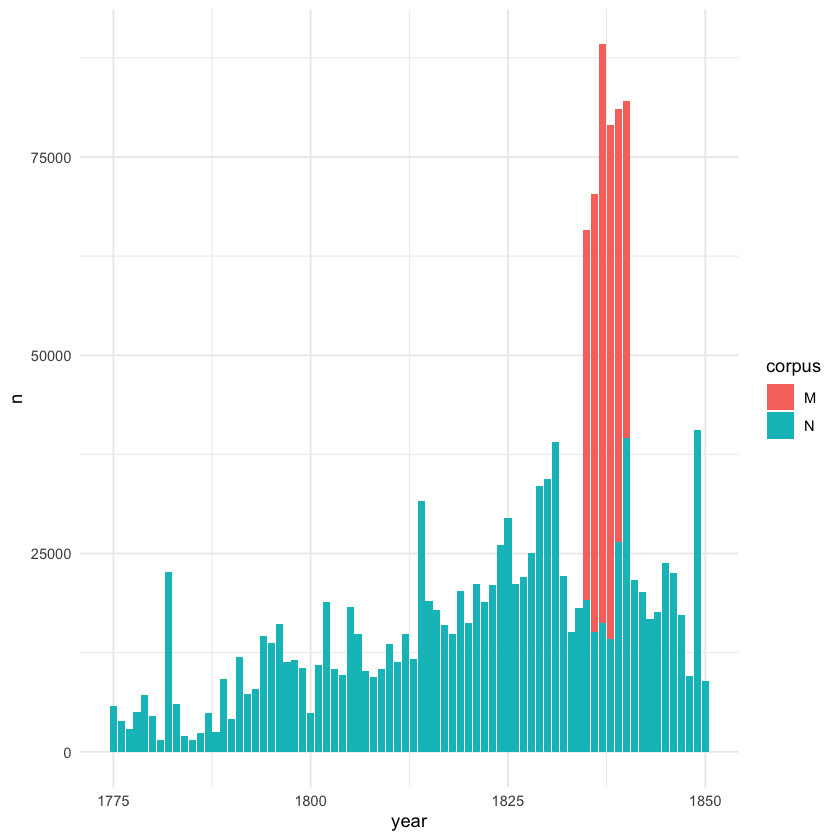

In [4]:
corpus_merged %>% 
    unnest_tokens(input = text_lemm, output = word, token = "words") %>% 
    mutate(word = str_remove_all(word, "\\d+|[[:punct:]]")) %>%
    group_by(corpus, year) %>% 
    count() %>% 
    ggplot(aes(x = year, y = n, fill = corpus)) + geom_col() + theme_minimal()

### meter distribution

In [5]:
main_meters <- corpus_merged %>% 
    # filter RNC texts in main meter
    filter(corpus == "N" & formula %in% c("iamb_4", "iamb_6", "trochee_4", "iamb_free")) %>% 
    # count number of poems in each slice in each meter
    group_by(decade, formula) %>% 
    count() %>% 
    pivot_wider(names_from = decade, values_from = n) %>%
    ungroup() %>% 
    select(-`1850`) %>% 
    # calculate total number of poems in each meter
    rowwise(formula) %>% mutate(total = sum(across(where(is.numeric))))

other_meters <- corpus_merged %>% 
    # calculate number of all other meters except for selected 4
    filter(corpus == "N" & !formula %in% c("iamb_4", "iamb_6", "trochee_4", "iamb_free")) %>% 
    group_by(decade) %>% 
    count() %>% 
    pivot_wider(names_from = decade, values_from = n) 

# attach meter labels as "other" and calculate sum
other_meters <- cbind(formula = "other", other_meters) %>% 
    ungroup() %>% 
    select(-`1850`) %>% 
    rowwise(formula) %>% mutate(total = sum(across(where(is.numeric))))

counts <- rbind(main_meters, other_meters)
counts

counts %>% ungroup() %>% summarise_if(is.numeric, sum)
#colSums(counts[,-1])

# percentage
print("Total percentage in the corpus of each meter")
counts[,17] %>% mutate(perc = round(total/colSums(counts[,17])*100, 1))

formula,1775,1780,1785,1790,1795,1800,1805,1810,1815,1820,1825,1830,1835,1840,1845,total
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
iamb_4,69,77,66,172,296,211,157,187,232,497,749,497,275,248,184,3917
iamb_6,107,96,55,78,101,71,145,156,110,126,122,95,74,119,69,1524
iamb_free,33,187,42,84,109,141,213,239,331,185,200,142,115,81,54,2156
trochee_4,23,10,14,87,121,78,67,83,59,72,122,172,185,302,104,1499
other,31,20,36,94,100,117,120,243,352,332,448,562,403,567,638,4063


1775,1780,1785,1790,1795,1800,1805,1810,1815,1820,1825,1830,1835,1840,1845,total
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
263,390,213,515,727,618,702,908,1084,1212,1641,1468,1052,1317,1049,13159


[1] "Total percentage in the corpus of each meter"


total,perc
<int>,<dbl>
3917,29.8
1524,11.6
2156,16.4
1499,11.4
4063,30.9


In [6]:
top_meters <- corpus_merged %>% 
    group_by(formula) %>% 
    count(sort = T) %>% 
    ungroup() %>%
    top_n(10)

top_meters

Selecting by n


formula,n
<chr>,<int>
iamb_4,5471
iamb_free,2168
trochee_4,2126
iamb_6,1886
iamb_5,974
iamb_other,630
iamb_3,491
other_6,375
amphibrach_4,325


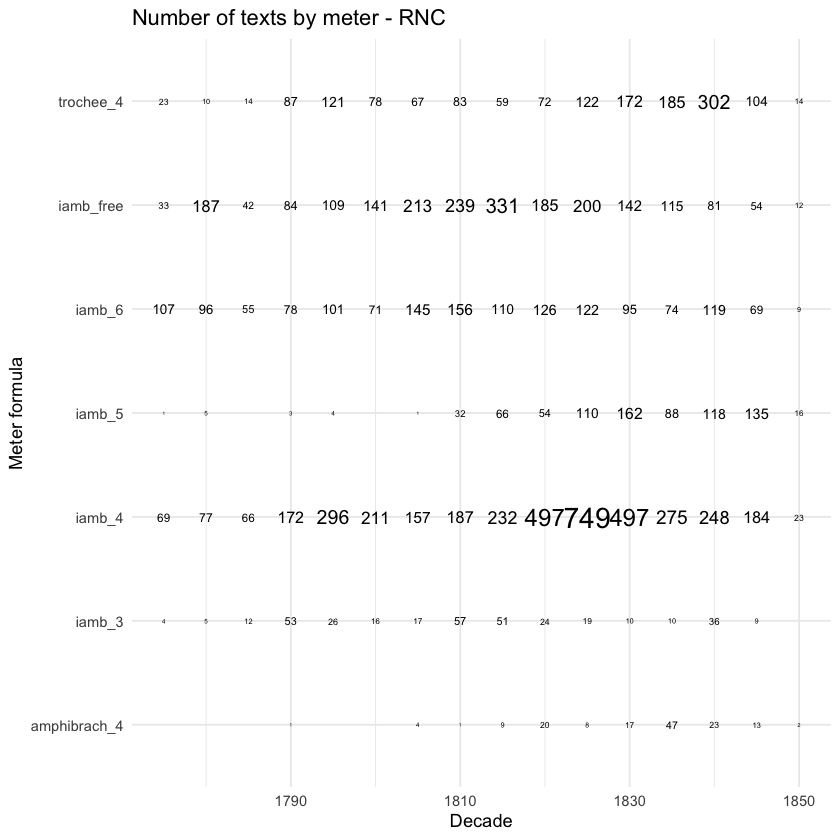

In [7]:
corpus_merged %>% 
    filter(corpus != "M") %>% 
    filter(formula %in% top_meters$formula & !str_detect(formula, "other")) %>%
    mutate(formula = str_remove_all(formula, "регулярная:")) %>% 
    group_by(decade, formula) %>% 
    count() %>% 
    ggplot(aes(x = decade, y = formula, size = n)) + 
        geom_text(aes(label=n)) + 
        theme_minimal() + 
        labs(x = "Decade", y = "Meter formula", title = "Number of texts by meter - RNC") + 
        theme(legend.position = "None")

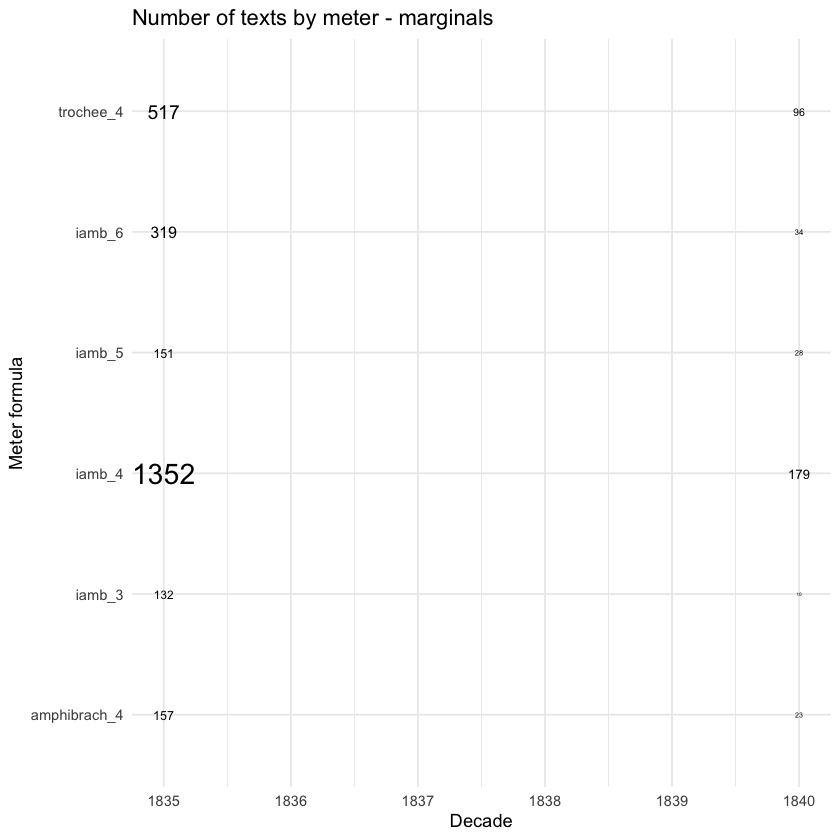

In [8]:
corpus_merged %>% 
    filter(corpus != "N") %>% 
    filter(formula %in% top_meters$formula & !str_detect(formula, "other")) %>%
    mutate(formula = str_remove_all(formula, "регулярная:")) %>% 
    group_by(decade, formula) %>% 
    count() %>% 
    ggplot(aes(x = decade, y = formula, size = n)) + 
        geom_text(aes(label=n)) + 
        theme_minimal() + 
        labs(x = "Decade", y = "Meter formula", title = "Number of texts by meter - marginals") + 
        theme(legend.position = "None")

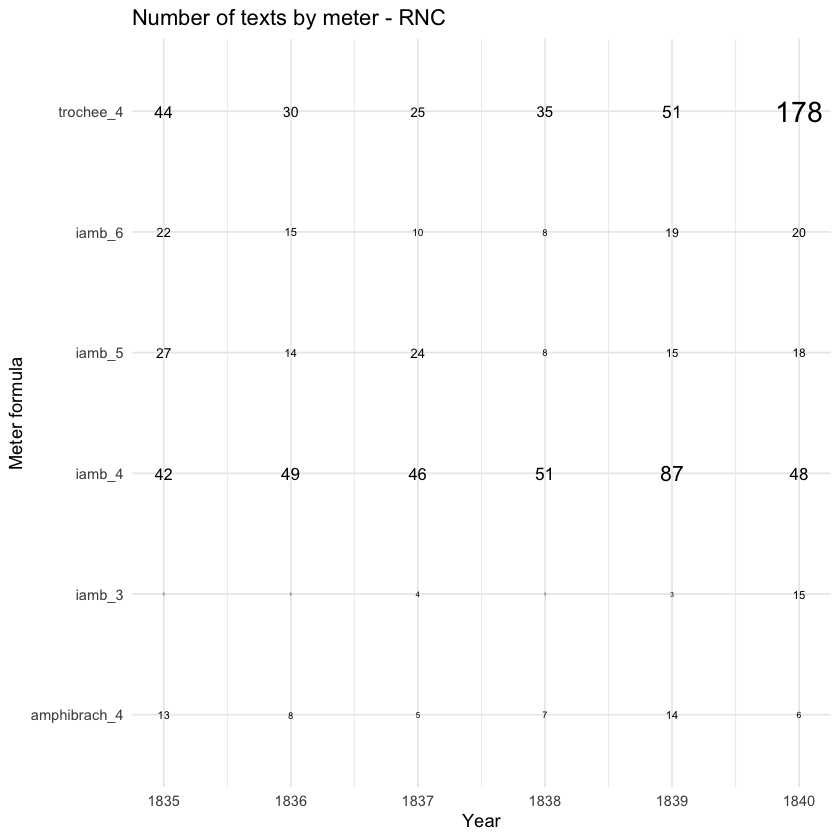

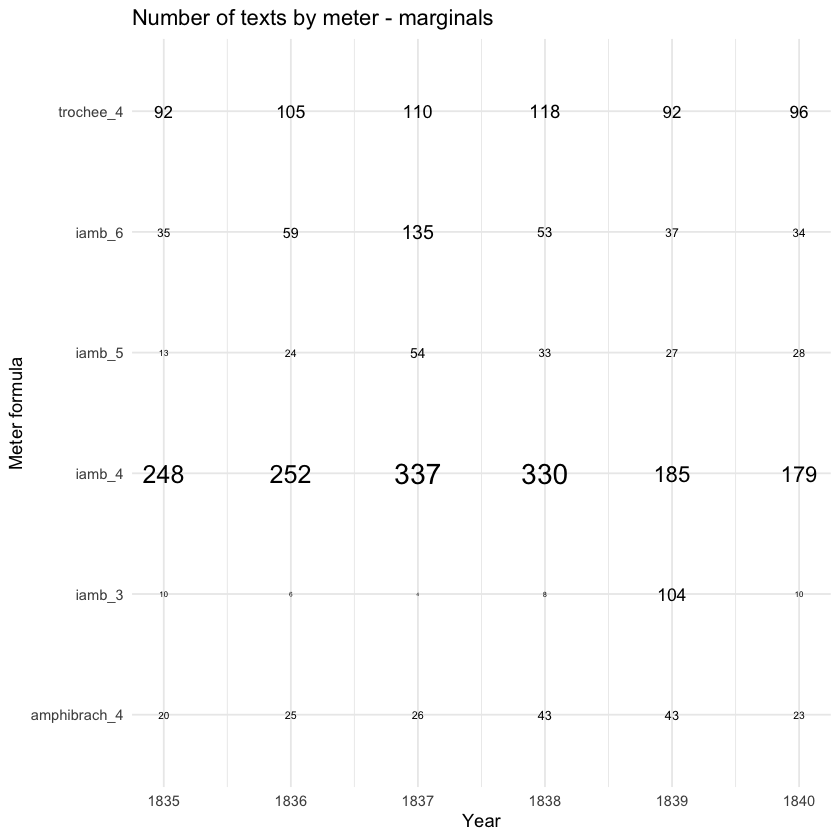

In [9]:
corpus_merged %>% 
    filter(corpus != "M") %>% 
    filter(year > 1834 & year < 1841) %>% 
    filter(formula %in% top_meters$formula & !str_detect(formula, "other|free")) %>%
    mutate(formula = str_remove_all(formula, "регулярная:")) %>% 
    group_by(year, formula) %>% 
    count() %>% 
    ggplot(aes(x = year, y = formula, size = n)) + 
        geom_text(aes(label=n)) + 
        theme_minimal() + 
        labs(x = "Year", y = "Meter formula", title = "Number of texts by meter - RNC") + 
        theme(legend.position = "None")

corpus_merged %>% 
    filter(corpus != "N") %>% 
    filter(formula %in% top_meters$formula & !str_detect(formula, "other")) %>%
    #mutate(formula = str_remove_all(formula, "регулярная:")) %>% 
    group_by(year, formula) %>% 
    count() %>% 
    ggplot(aes(x = year, y = formula, size = n)) + 
        geom_text(aes(label=n)) + 
        theme_minimal() + 
        labs(x = "Year", y = "Meter formula", title = "Number of texts by meter - marginals") + 
        theme(legend.position = "None")

## DTM creation

In [ ]:
# load stoplist
ru_stop <- tibble(word = readLines("data/stopwords_ru.txt"))

# load data
# load("../data/corpus_merged.Rda")

In [ ]:
glimpse(corpus_merged)

Prepare id for dtm

In [ ]:
corpus_to_dtm <- corpus_merged %>% 
    # create first column id
    mutate(first_line = str_extract(text_lemm, "^.*?\\n")) %>% 
    mutate(first_line = str_to_title(first_line)) %>% 
    mutate(first_line = str_remove_all(first_line, "\\n|\\s|\\W+")) %>% 
    mutate(author = str_remove_all(author, "\\s|\\W+")) %>% 
    # unite main columns to doc-id
    unite(doc, c("id", "year", "author", "formula"), sep = "___") %>% 
    # select only id and text in the final df
    select(doc, text_lemm) 

In [ ]:
# tokenisation
corpus_tokens <- corpus_to_dtm %>% 
  unnest_tokens(input = text_lemm, output = word, token = "words") %>% 
  anti_join(ru_stop, by = "word") %>% 
  filter(str_detect(word, "[А-Яа-я]"))

 head(corpus_tokens)

In [ ]:
# count words in each document
tokens_count <- corpus_tokens %>% 
  group_by(doc) %>% 
  count(word)

# count 5k MFW
ranks <- corpus_tokens %>% 
  count(word, sort = TRUE) %>% 
  head(5000) %>% 
  select(-n)

head(ranks, 10)

In [ ]:
# select only MFW
counts_dtm <- tokens_count %>% 
  right_join(ranks, by = "word")

# check
length(unique(counts_dtm$word))

In [ ]:
# cast dtm
dtm_iamb4_experiment <- counts_dtm %>% cast_dtm(document = doc,
                                       term = word,
                                       value = n)

dtm_iamb4_experiment

In [ ]:
save(dtm_iamb4_experiment, file = "data/dtm_iamb4_experiment.Rda")

In [ ]:
# t35 <- corpus_35_short %>% 
#   select(text_id, text_raw) %>% 
#   mutate(twolines = str_extract(text_raw, "^.*?\\n.*?\\n"),
#          twolines = tolower(twolines),
#          twolines = str_remove_all(twolines, "[[:punct:]]|[[:space:]]|\\n")) %>% 
#   select(-text_raw) %>% 
#   head(10)
# 
# t_rnc <- c19 %>% 
#   mutate(text_id = paste0("N_", Unnamed..0)) %>% 
#   select(text_id, text_raw) %>% 
#   mutate(twolines = str_extract(text_raw, "^.*?\\n.*?\\n"),
#          twolines = tolower(twolines),
#          twolines = str_remove_all(twolines, "[[:punct:]]|[[:space:]]|\\n")) %>% 
#   select(-text_raw) %>% 
#   filter(!is.na(twolines)) %>% 
#   head(10)
# 
# head(t_rnc)
# 
# mean(nchar(t35$twolines))
# mean(nchar(t_rnc$twolines))
# 
# 
# 
# x <- NULL
# y <- NULL
# dist <- NULL
# 
# for (i in 1:nrow(t35)) {
#   
#   for (j in 1:nrow(t_rnc)) {
#     
#     x <- c(x, t35$text_id[i])
#     
#     y <- c(y, t_rnc$text_id[j])
#     
#     dist <- c(dist, stringdist(t35$twolines[i], t_rnc$twolines[j], method = "lv"))
#     
#   }
# }
# 
# tibble(x = x,
#        y = y, 
#        dist = dist) %>% 
#   filter(dist < 20)